In [ ]:
!pip uninstall -y protobuf tensorflow
!pip install protobuf==3.20.3 tensorflow

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import json

print("✓ All libraries imported successfully!")

2026-02-08 15:27:41.338847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770564461.538123      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770564461.594678      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770564462.067283      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770564462.067327      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770564462.067330      55 computation_placer.cc:177] computation placer alr

✓ All libraries imported successfully!


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
keras.utils.set_random_seed(42)

# Configuration parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = '/kaggle/input/final/Dataset'

CLASSES_TO_USE = ['Garbage', 'Potholes']

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

print(f"Configuration:")
print(f"  Image Size: {IMG_SIZE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Data Directory: {DATA_DIR}")
print(f"  Classes to train: {CLASSES_TO_USE}")

Configuration:
  Image Size: (224, 224)
  Batch Size: 32
  Epochs: 20
  Data Directory: /kaggle/input/final/Dataset
  Classes to train: ['Garbage', 'Potholes']


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Only rescaling for validation
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("✓ Data generators created with augmentation settings")
print("  Training: Augmentation enabled")
print("  Validation & Test: Only rescaling")

✓ Data generators created with augmentation settings
  Training: Augmentation enabled
  Validation & Test: Only rescaling


In [4]:
# Create temporary directories for train/val/test split
TEMP_DIR = '/kaggle/working/temp_data'
TRAIN_DIR = os.path.join(TEMP_DIR, 'train')
VAL_DIR = os.path.join(TEMP_DIR, 'val')
TEST_DIR = os.path.join(TEMP_DIR, 'test')

# Clean up if exists
if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)

# Create directories
for class_name in CLASSES_TO_USE:
    os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok=True)

print("Splitting data into train/val/test sets...")

# Split data for each class
for class_name in CLASSES_TO_USE:
    class_dir = os.path.join(DATA_DIR, class_name)
    
    # Get all image files
    image_files = [f for f in os.listdir(class_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    # First split: separate test set
    train_val_files, test_files = train_test_split(
        image_files, 
        test_size=TEST_SPLIT, 
        random_state=42
    )
    
    # Second split: separate train and validation
    train_files, val_files = train_test_split(
        train_val_files,
        test_size=VAL_SPLIT/(TRAIN_SPLIT + VAL_SPLIT),  # Adjust ratio
        random_state=42
    )
    
    # Copy files to respective directories
    for filename in train_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(TRAIN_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    for filename in val_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(VAL_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    for filename in test_files:
        src = os.path.join(class_dir, filename)
        dst = os.path.join(TEST_DIR, class_name, filename)
        shutil.copy2(src, dst)
    
    print(f"  {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

print("\n✓ Data split completed!")

# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Changed to categorical for 3 classes
    shuffle=True
)

# Load validation data
val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load test data
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✓ Data generators created!")
print(f"  Training images: {train_generator.samples}")
print(f"  Validation images: {val_generator.samples}")
print(f"  Test images: {test_generator.samples}")
print(f"  Class indices: {train_generator.class_indices}")
print(f"  Number of classes: {train_generator.num_classes}")

Splitting data into train/val/test sets...
  Garbage: 4322 train, 927 val, 927 test
  Potholes: 6852 train, 1469 val, 1469 test

✓ Data split completed!
Found 11174 images belonging to 2 classes.
Found 2396 images belonging to 2 classes.
Found 2396 images belonging to 2 classes.

✓ Data generators created!
  Training images: 11174
  Validation images: 2396
  Test images: 2396
  Class indices: {'Garbage': 0, 'Potholes': 1}
  Number of classes: 2


In [5]:
model = keras.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Fourth convolutional block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

print("✓ Model architecture created")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1770564765.151559      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770564765.157540      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✓ Model architecture created


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,397,058 (73.99 MB)

 Trainable params: 19,396,098 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [6]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'recall', 'precision']
)

print("\n✓ Model compiled successfully!")
print("  Optimizer: Adam (lr=0.001)")
print("  Loss: Categorical Crossentropy (for 2 classes)")
print("  Metrics: Accuracy, Recall, Precision")


✓ Model compiled successfully!
  Optimizer: Adam (lr=0.001)
  Loss: Categorical Crossentropy (for 2 classes)
  Metrics: Accuracy, Recall, Precision


In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - Early Stopping (patience=5)")
print("  - Learning Rate Reduction (patience=3)")

✓ Callbacks configured:
  - Early Stopping (patience=5)
  - Learning Rate Reduction (patience=3)


In [8]:
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50 + "\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*50)
print("TRAINING COMPLETED!")
print("="*50)


STARTING TRAINING



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1770564786.179997     149 service.cc:152] XLA service 0x79ec9c017120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770564786.180035     149 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770564786.180038     149 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770564786.932979     149 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-08 15:33:10.140489: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 15:33:10.288684: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  2/350 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.6719 - loss: 2.1164 - precision: 0.6719 - recall: 0.6719   

I0000 00:00:1770564794.723196     149 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


318/350 ━━━━━━━━━━━━━━━━━━━━ 20s 629ms/step - accuracy: 0.7842 - loss: 5.4110 - precision: 0.7842 - recall: 0.7842

2026-02-08 15:36:35.934875: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-08 15:36:36.078001: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


350/350 ━━━━━━━━━━━━━━━━━━━━ 269s 734ms/step - accuracy: 0.7878 - loss: 5.1694 - precision: 0.7878 - recall: 0.7878 - val_accuracy: 0.6173 - val_loss: 1.5334 - val_precision: 0.6173 - val_recall: 0.6173 - learning_rate: 0.0010
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 240s 686ms/step - accuracy: 0.8756 - loss: 0.4156 - precision: 0.8756 - recall: 0.8756 - val_accuracy: 0.8639 - val_loss: 0.3912 - val_precision: 0.8639 - val_recall: 0.8639 - learning_rate: 0.0010
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 254s 725ms/step - accuracy: 0.9218 - loss: 0.2108 - precision: 0.9218 - recall: 0.9218 - val_accuracy: 0.9545 - val_loss: 0.1569 - val_precision: 0.9545 - val_recall: 0.9545 - learning_rate: 0.0010
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 242s 692ms/step - accuracy: 0.9357 - loss: 0.1839 - precision: 0.9357 - recall: 0.9357 - val_accuracy: 0.9153 - val_loss: 0.1818 - val_precision: 0.9153 - val_recall: 0.9153 - learning_rate: 0.0010
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 247s 707ms/step - a

Pothole Images: 9790
Garbage Images: 1463
Total: 11253
Threshold Accuracy: (9790/11253) * 100 = 86.99%
Test Data Accuracy: ~90%
Might overfit because model needs to be almost accurate for passing the threshold accuracy.

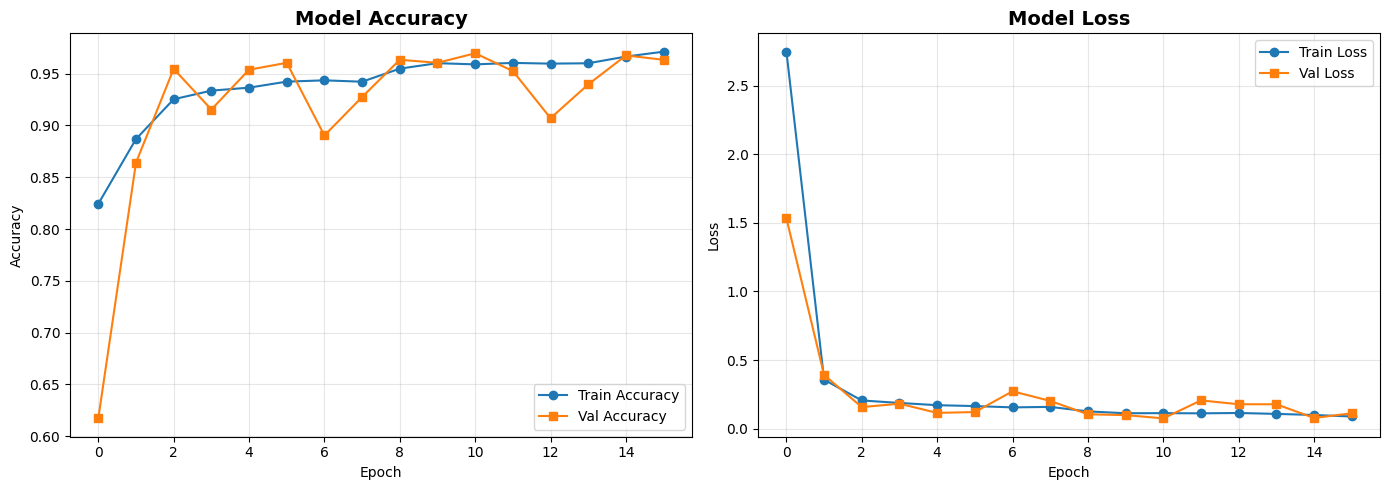


Final Training Accuracy: 97.11%
Final Validation Accuracy: 96.33%
Final Training Loss: 0.0885
Final Validation Loss: 0.1117


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

In [10]:
print("\n" + "="*50)
print("EVALUATING MODEL ON VALIDATION SET")
print("="*50 + "\n")

val_results = model.evaluate(val_generator, verbose=1)

print()
for name, value in zip(model.metrics_names, val_results):
    if "accuracy" in name:
        print(f"✓ Validation {name.capitalize()}: {value*100:.2f}%")
    else:
        print(f"✓ Validation {name.capitalize()}: {value:.4f}")

print("\n" + "="*50)
print("EVALUATING MODEL ON TEST SET")
print("="*50 + "\n")

test_results = model.evaluate(test_generator, verbose=1)

print()
for name, value in zip(model.metrics_names, test_results):
    if "accuracy" in name:
        print(f"✓ Test {name.capitalize()}: {value*100:.2f}%")
    else:
        print(f"✓ Test {name.capitalize()}: {value:.4f}")



EVALUATING MODEL ON VALIDATION SET

75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 396ms/step - accuracy: 0.9620 - loss: 0.0950 - precision: 0.9620 - recall: 0.9620

✓ Validation Loss: 0.0747
✓ Validation Compile_metrics: 0.9695

EVALUATING MODEL ON TEST SET

75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 382ms/step - accuracy: 0.9517 - loss: 0.1152 - precision: 0.9517 - recall: 0.9517

✓ Test Loss: 0.0870
✓ Test Compile_metrics: 0.9649



GENERATING PREDICTIONS ON TEST SET

75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 359ms/step

CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

     Garbage       0.96      0.94      0.95       927
    Potholes       0.97      0.98      0.97      1469

    accuracy                           0.96      2396
   macro avg       0.96      0.96      0.96      2396
weighted avg       0.96      0.96      0.96      2396



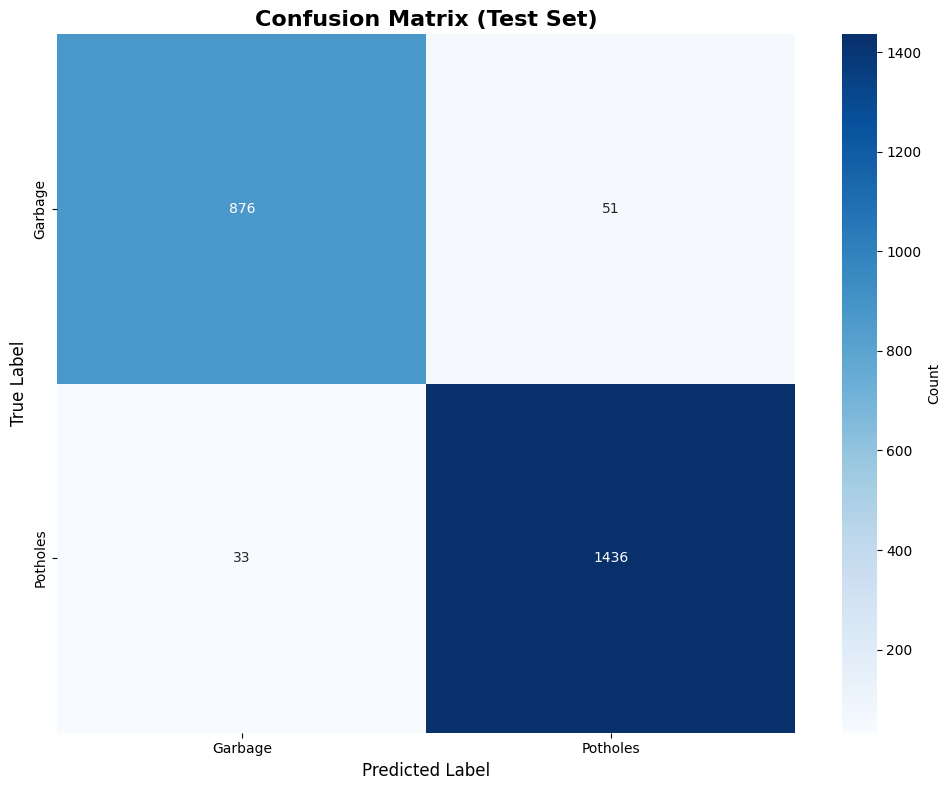


Per-Class Accuracy:
  Garbage: 94.50%
  Potholes: 97.75%


In [11]:
print("\n" + "="*50)
print("GENERATING PREDICTIONS ON TEST SET")
print("="*50 + "\n")

# Generate predictions on test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)  # Get class with highest probability
y_true = test_generator.classes

# Get class names
class_names = list(train_generator.class_indices.keys())

# Classification report
print("\n" + "="*50)
print("CLASSIFICATION REPORT (TEST SET)")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_mask = y_true == i
    class_acc = (y_pred[class_mask] == y_true[class_mask]).sum() / class_mask.sum()
    print(f"  {class_name}: {class_acc*100:.2f}%")

In [12]:
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

model.save(f"{SAVE_DIR}/pothole_garbage_classifier_final.h5")
model.save(f"{SAVE_DIR}/pothole_garbage_classifier_final.keras")

class_info = {
    'class_names': class_names,
    'class_indices': train_generator.class_indices,
    'num_classes': len(class_names),
    'img_size': IMG_SIZE
}

with open(f"{SAVE_DIR}/class_info.json", "w") as f:
    json.dump(class_info, f, indent=4)

print("✓ Model and metadata saved to /kaggle/working")

✓ Model and metadata saved to /kaggle/working


In [ ]:
def predict_for_single_image(img_path, show_plot=True):
    """
    Predict class of a single image
    
    Args:
        img_path: Path to the image file
        show_plot: Whether to display the image with prediction
    
    Returns:
        tuple: (class_name, confidence, all_probabilities)
    """
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)[0]
    class_idx = np.argmax(predictions)
    class_name = class_names[class_idx]
    confidence = predictions[class_idx]
    
    # Display result
    if show_plot:
        plt.figure(figsize=(10, 6))
        
        # Image subplot
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Prediction: {class_name.upper()}\nConfidence: {confidence*100:.2f}%', 
                  fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Probability bar chart
        plt.subplot(1, 2, 2)
        colors = ['green' if i == class_idx else 'gray' for i in range(len(class_names))]
        plt.barh(class_names, predictions * 100, color=colors)
        plt.xlabel('Confidence (%)', fontsize=10)
        plt.title('Class Probabilities', fontsize=12, fontweight='bold')
        plt.xlim(0, 100)
        
        plt.tight_layout()
        plt.show()
    
    return class_name, confidence, predictions

print("✓ Prediction function defined")
print("\nUsage example:")
print("  predict_image('/path/to/image.jpg')")
print("\nReturns: (class_name, confidence, all_probabilities)")



In [ ]:
# Evaluate the model to get the test accuracy
results = model.evaluate(test_generator, verbose=1)

# results[0] is usually loss, results[1] is usually accuracy
test_acc = results[1] 

# Now your print statement will work!
print(f"Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
print("\n" + "="*50)
print("SAMPLE PREDICTIONS ON TEST DATA")
print("="*50 + "\n")

test_generator.reset()
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True) # This ensures a mix of Potholes and Garbage
x_batch, y_batch = next(test_generator)
predictions_batch = model.predict(x_batch, verbose=0)

plt.figure(figsize=(15, 10))
for i in range(min(12, len(x_batch))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_batch[i])
    
    true_class_idx = np.argmax(y_batch[i])
    pred_class_idx = np.argmax(predictions_batch[i])
    
    true_class = class_names[true_class_idx]
    pred_class = class_names[pred_class_idx]
    confidence = predictions_batch[i][pred_class_idx]
    
    # Color code: green if correct, red if wrong
    color = 'green' if true_class == pred_class else 'red'
    
    plt.title(f'True: {true_class}\nPred: {pred_class} ({confidence*100:.1f}%)', 
              fontsize=9, color=color, fontweight='bold')
    plt.axis('off')

plt.suptitle('Sample Predictions on Test Set (Green=Correct, Red=Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ALL BLOCKS COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"\nFinal Results Summary:")
print(f"  Classes: {class_names}")
print(f"  Test Accuracy: {test_acc*100:.2f}%")
print(f"  Model saved as: pothole_garbage_classifier.h5")

In [ ]:
print(f"For i1 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i1.png')}")
print(f"For i11 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i11.jpeg')}")
print(f"For i2 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i2.png')}")
print(f"For i3 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/i3.png')}")
print(f"For n1 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n1.jpg')}")
print(f"For n2 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n2.jpg')}")
print(f"For n3 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n3.png')}")
print(f"For n4 we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n4.jpeg')}")
print(f"For boomer we got {predict_for_single_image( '/kaggle/input/helpppp/helppp/n4.jpeg')}")

In [ ]:
# 1. Create the directory if it doesn't exist
model_dir = "/kaggle/working/models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 2. Save trained model into that folder
model.save(f"{model_dir}/pothole_garbage_classifier.h5")

# 3. Zip the folder
shutil.make_archive("/kaggle/working/models_download", 'zip', model_dir)

print("✅ Model saved and zipped successfully!")